# Plot persistence times vs. clade 

This reads in the output of `human-tips-vs-persistence-times` and looks at the inferred clusters and groups by clade and region. The analysis in `human-tips-vs-persistence-times` runs Gytis's subtree function to infer every introduction from wild to domestic birds, calculates the total persistence time of that introduction, and also counts the number of human tips in that introduction. This is done across the entire posterior, but is the equivalent of looking at every introduction as plotted in an exploded tree, with a small exception: in the standard exploded trees, I plot the amount of time circulation proceeds within domestic, and I do NOT plot transitions into human. In this analysis, I only stop the traversal if we transition back into the wild deme. So I allow the traversal to continue through human and domestic branches and tips. 

In this notebook, I am just doing a very simple mapping of each cluster. For each cluster, pull out the clades of each tip in it. Then group them into some higher order groupings and see whether it correlates with persistence times at all. I also want to mmake sure that this is somewhat reasonable based on the geographic distribution of the clades. Here is a scatter plot from Nextstrain showing clade by geography 

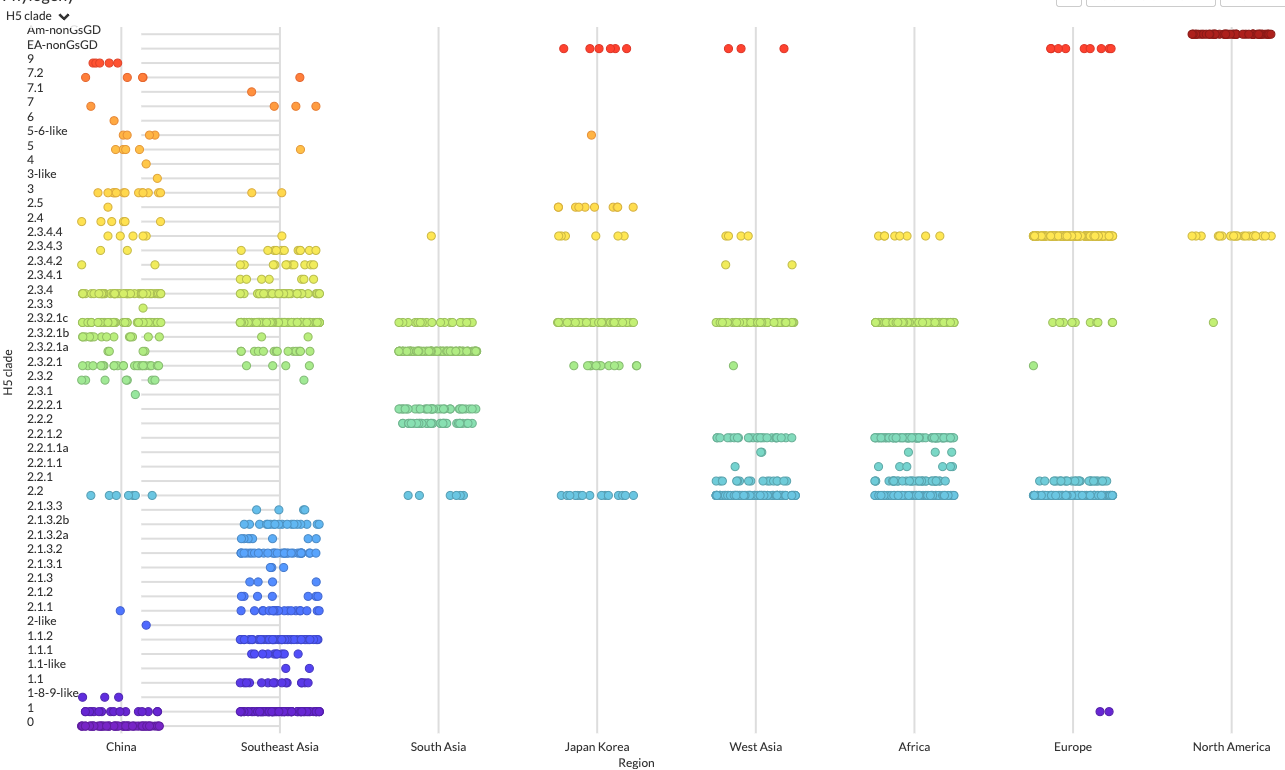

Basically, clades 1 and 2.1 are only really present in China and Southeast Asia. Everything else is found all over the world. How do we properly account for this? 

1. For the question "Is clade a predictor of human tips while controlling for circulation time and region?", I think that maybe this still works. What the regression is doing is asking: 

In [1]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import time
from io import StringIO

import rpy2
%load_ext rpy2.ipython

In [2]:
from datetime import date
current_date = str(date.today())

# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [3]:
h5n1_clades_file = "/Users/lmoncla/src/avian-flu/clade-labeling/h5n1-clades.tsv"

In [4]:
h5n1_clades_dict = {}

with open(h5n1_clades_file, "r") as infile: 
    for line in infile: 
        strain = line.split("\t")[0]
        clade = line.split("\t")[1].strip()
        h5n1_clades_dict[strain] = clade
        
#print(h5n1_clades_dict)

In [5]:
# read in persistence timees tsv output 
persistence_times = "beast-runs/2022-04-19-mascot-3deme-skyline-fixed-muts-logger/combined-2022-06-01.muts-circulation-time-vs-human-tips-2022-06-07.tsv"

persistence_times_dict = {}

with open(persistence_times, "r") as infile:
    for line in infile:
        
        if "subtree_number" not in line:
            tree_number = line.split("\t")[1]
            tips_list = line.split("\t")[5].replace("[","").replace("]","").replace("\'","").strip().split(", ")
            persistence_times_dict[str(tips_list)] = {"clades":[],"regions":[]}
        
            for t in tips_list:
                strain_name = t.split("|")[0]
                region = t.split("|")[4]
                
                if strain_name in h5n1_clades_dict:
                    persistence_times_dict[str(tips_list)]['clades'].append(h5n1_clades_dict[strain_name])
                    persistence_times_dict[str(tips_list)]['regions'].append(region)
                
                else:
                    print("no clade for", strain_name)

In [6]:
print(len(persistence_times_dict))

10307


In [7]:
# clade_mapping = {"0":["0"],
#                  "1":["1","1.1","1.1-like","1.1.1","1.1.2"],
#                  "2.1":["2-like","2.1.1","2.1.2","2.1.3","2.1.3.1","2.1.3.2","2.1.3.2a","2.1.3.2b","2.1.3.3"], 
#                  "2.2":["2.2","2.2.1","2.2.1.1","2.2.1.1a","2.2.1.2","2.2.2","2.2.2.1"], 
#                  "2.3":["2.3.1","2.3.2","2.3.2.1","2.3.2.1a","2.3.2.1b","2.3.2.1c","2.3.3","2.3.4","2.3.4-like","2.3.4.1","2.3.4.2","2.3.4.3","2.3.4.4"],
#                  "other":["2.4","2.5","3","3-like","4","5","5-6-like","6","7","7.1","7.2","8","8-9-like","9","EA-nonGsGD","Am-nonGsGD","1-8-9-like"]}

In [8]:
# condense clades into groups
clade_mapping = {
"0":"0",
 
"1":"1",
"1.1":"1",
"1.1-like":"1",
"1.1.1":"1",
"1.1.2":"1",
 
"2.1":"2.1",
"2-like":"2.1",
"2.1.1":"2.1",
"2.1.2":"2.1",
"2.1.3":"2.1",
"2.1.3.1":"2.1",
"2.1.3.2":"2.1",
"2.1.3.2a":"2.1",
"2.1.3.2b":"2.1",
"2.1.3.3":"2.1",
 
"2.2":"2.2",
"2.2.1":"2.2",
"2.2.1.1":"2.2",
"2.2.1.1a":"2.2",
"2.2.1.2":"2.2",
"2.2.2":"2.2",
"2.2.2.1":"2.2",
 
"2.3":"2.3",
"2.3.2":"2.3",
"2.3.2.1":"2.3",
"2.3.2.1a":"2.3",
"2.3.2.1b":"2.3",
"2.3.2.1c":"2.3",
                 
"2.3.4":"2.3.4",
"2.3.4-like":"2.3.4",
"2.3.4.1":"2.3.4",
"2.3.4.2":"2.3.4",
"2.3.4.3":"2.3.4",
"2.3.4.4":"2.3.4",
 
"2.4":"other",
"2.5":"other",
"3":"other",
"3-like":"other",
"4":"other",
"5":"other",
"5-6-like":"other",
"6":"other",
"7":"other",
"7.1":"other",
"7.2":"other",
"8":"other",
"8-9-like":"other",
"9":"other",
"EA-nonGsGD":"non-GsGd",
"Am-nonGsGD":"non-GsGd",
"1-8-9-like":"other"}

In [7]:
# condense clades into groups
clade_mapping = {
"0":"0/1",
"1":"0/1",
"1.1":"0/1",
"1.1-like":"0/1",
"1.1.1":"0/1",
"1.1.2":"0/1",
 
"2.1":"2.1",
"2-like":"2.1",
"2.1.1":"2.1",
"2.1.2":"2.1",
"2.1.3":"2.1",
"2.1.3.1":"2.1",
"2.1.3.2":"2.1",
"2.1.3.2a":"2.1",
"2.1.3.2b":"2.1",
"2.1.3.3":"2.1",
 
"2.2":"2.2",
"2.2.1":"2.2",
"2.2.1.1":"2.2",
"2.2.1.1a":"2.2",
"2.2.1.2":"2.2",
"2.2.2":"2.2",
"2.2.2.1":"2.2",
 
"2.3":"2.3x",
"2.3.1":"2.3x",
"2.3.2":"2.3x",
"2.3.2.1":"2.3x",
"2.3.2.1a":"2.3x",
"2.3.2.1b":"2.3x",
"2.3.2.1c":"2.3.2.1c",
    
"2.3.3":"2.3.4x",           
"2.3.4":"2.3.4x",
"2.3.4-like":"2.3.4x",
"2.3.4.1":"2.3.4x",
"2.3.4.2":"2.3.4x",
"2.3.4.3":"2.3.4x",
"2.3.4.4":"2.3.4x",
 
"2.4":"other",
"2.5":"other",
"3":"other",
"3-like":"other",
"4":"0/1",
"5":"0/1",
"5-6-like":"0/1",
"6":"0/1",
"7":"0/1",
"7.1":"0/1",
"7.2":"0/1",
"8":"0/1",
"8-9-like":"0/1",
"9":"0/1",
"EA-nonGsGD":"non-GsGd",
"Am-nonGsGD":"non-GsGd",
"1-8-9-like":"0/1", 
"?":"unknown"}

In [8]:
# let's see if we can condense these into a few categories: 0, 1, 2.1, 2.2, 2.3, and other 

persistence_times_dict2 = {}
mixed = 0
single = 0
mixed_regions = 0
single_regions = 0

# for each cluster
for p in persistence_times_dict: 
    clade_groups = []
    region_groups = []
    
    persistence_times_dict2[p] = {"clades":"", "regions":""}
    
    if p != "['tips_in_subtree']":
        # for each clade in the cluster, assign it a clade group 
        for clade in persistence_times_dict[p]['clades']:
            clade_group = clade_mapping[clade]
            clade_groups.append(clade_group)

        if len(set(clade_groups)) > 1:
            mixed += 1
            persistence_times_dict2[p]['clades'] = "mixed"
        else: 
            single += 1
            persistence_times_dict2[p]['clades'] = str(set(clade_groups)).replace("{","").replace("}","").replace("\'","")

        for region in persistence_times_dict[p]['regions']:
            region_groups.append(region)

        if len(set(region_groups)) > 1:
            mixed_regions += 1
            persistence_times_dict2[p]['regions'] = "mixed"
        else: 
            single_regions += 1
            persistence_times_dict2[p]['regions'] = str(set(region_groups)).replace("{","").replace("}","").replace("\'","")

            
print(mixed, single)
print(mixed_regions, single_regions)

611 9696
4562 5745


In [9]:
#persistence_times_dict2

In [10]:
clades_df = pd.DataFrame.from_dict(persistence_times_dict2, orient="index")
clades_df.reset_index(inplace=True)
clades_df.columns = ["tips_in_subtree","clade_group", "region_group"]
clades_df.head()

,tips_in_subtree,clade_group,region_group
0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China
1,['A/Chicken/HongKong/786/1997|1997.0|1997-XX-X...,0/1,China
2,['A/HongKong/97/1998|1998.0|1998-XX-XX|Human|C...,0/1,China
3,['A/duck/Guangxi/07/1999|1999.0|1999-XX-XX|Avi...,0/1,China
4,['A/Goose/HongKong/3853/2000|2000.0|2000-XX-XX...,0/1,China


In [11]:
# merge with other dataframee 
# read dataframe back in 
df = pd.read_csv("beast-runs/2022-04-19-mascot-3deme-skyline-fixed-muts-logger/combined-2022-06-01.muts-circulation-time-vs-human-tips-2022-06-07.tsv", sep="\t")
print(len(df))
df.head()

161168


,Unnamed: 0,tree_number,subtree_number,circulation_time,n_human_tips,tips_in_subtree
0,0,1,1,0.705697,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...
1,0,1,2,0.382224,0,['A/Chicken/HongKong/786/1997|1997.0|1997-XX-X...
2,0,1,3,0.770590,1,['A/HongKong/97/1998|1998.0|1998-XX-XX|Human|C...
3,0,1,4,1.059893,0,['A/duck/Guangxi/07/1999|1999.0|1999-XX-XX|Avi...
4,0,1,5,0.390459,0,['A/Goose/HongKong/3853/2000|2000.0|2000-XX-XX...


In [12]:
df_with_clade = df.merge(clades_df, on="tips_in_subtree")
print(len(df_with_clade))
df_with_clade.head()

161168


,Unnamed: 0,tree_number,subtree_number,circulation_time,n_human_tips,tips_in_subtree,clade_group,region_group
0,0,1,1,0.705697,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China
1,0,3,1,0.208335,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China
2,0,4,3,0.813138,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China
3,0,5,3,0.681485,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China
4,0,6,2,0.550684,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China


In [13]:
def return_n_tips(tips_in_subtree_column):
    tips_list = tips_in_subtree_column.split(",")
    n_tips = len(tips_list)
    return(n_tips)

In [14]:
df_with_clade['n_tips_in_subtree'] = df['tips_in_subtree'].apply(return_n_tips)
df_with_clade.head()

,Unnamed: 0,tree_number,subtree_number,circulation_time,n_human_tips,tips_in_subtree,clade_group,region_group,n_tips_in_subtree
0,0,1,1,0.705697,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1
1,0,3,1,0.208335,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1
2,0,4,3,0.813138,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1
3,0,5,3,0.681485,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1
4,0,6,2,0.550684,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1


In [15]:
# plot together 
df_with_clade['human_tips'] = np.where(df_with_clade['n_human_tips']==0, 0, 1)
df_with_clade.head()

,Unnamed: 0,tree_number,subtree_number,circulation_time,n_human_tips,tips_in_subtree,clade_group,region_group,n_tips_in_subtree,human_tips
0,0,1,1,0.705697,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1,0
1,0,3,1,0.208335,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1,0
2,0,4,3,0.813138,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1,0
3,0,5,3,0.681485,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1,0
4,0,6,2,0.550684,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1,0


In [16]:
print(set(df_with_clade['clade_group'].tolist()))

{'other', '2.2', '2.3x', '2.1', '2.3.4x', '0/1', 'mixed', '2.3.2.1c'}


In [17]:
print(len(df_with_clade[df_with_clade['clade_group'] == "mixed"]))
print(len(df_with_clade[df_with_clade['clade_group'] == "other"]))
print(len(df_with_clade))

657
3345
161168


## how many introductions feature a mixed or "other" clade? 

0.2% of introductions are mixed, and 5% are other. So 95% of introductions are of clade 0, 1, 2.1, 2.2, 2.3, or 2.3.4. 

In [18]:
# remove rows with other; these are all very small clades that are sort of odd, and I don't think we need to include them 
# print(len(df_with_clade))
# df_with_clade = df_with_clade[df_with_clade['clade_group']!='other']
# print(len(df_with_clade))

### Regression models: 1 variable at a time

In [19]:
%%R -w 800 -h 500 -u px -i df_with_clade

reg1 <- lm(n_human_tips~circulation_time,data=df_with_clade) 
print(summary(reg1))

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



Call:
lm(formula = n_human_tips ~ circulation_time, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.478  -0.464   0.367   0.752  93.470 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.932446   0.008551    -109   <2e-16 ***
circulation_time  1.533786   0.003687     416   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.96 on 161166 degrees of freedom
Multiple R-squared:  0.5178,	Adjusted R-squared:  0.5178 
F-statistic: 1.731e+05 on 1 and 161166 DF,  p-value: < 2.2e-16



In [20]:
%%R -w 800 -h 500 -u px -i df_with_clade

reg1 <- lm(n_human_tips~circulation_time+clade_group+region_group,data=df_with_clade) 
print(summary(reg1))


Call:
lm(formula = n_human_tips ~ circulation_time + clade_group + 
    region_group, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.275  -0.422   0.253   0.644  84.108 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -0.632893   0.034402 -18.397  < 2e-16 ***
circulation_time            1.388096   0.004849 286.268  < 2e-16 ***
clade_group2.1              4.765560   0.065183  73.111  < 2e-16 ***
clade_group2.2             -0.216673   0.034490  -6.282 3.35e-10 ***
clade_group2.3.2.1c        -0.077781   0.026743  -2.908  0.00363 ** 
clade_group2.3.4x          -0.041596   0.034235  -1.215  0.22436    
clade_group2.3x            -0.547339   0.033641 -16.270  < 2e-16 ***
clade_groupmixed           11.384438   0.117608  96.800  < 2e-16 ***
clade_groupother            0.522684   0.054834   9.532  < 2e-16 ***
region_groupChina          -0.676443   0.029888 -22.632  < 2e-16 ***
region_groupEurope     

### Each clade individually: Do human tips correlate with clade after controlling for circulation time? 

I want to know: Does the number of human tips correlate with clade and if so, does that change when we account for how long that introduction has been circulating? 

Said another way: Does clade have an effect on the number of human tips after controlling for circulation time? 

Make some extra dataframe columns for whether you are in eeach clade, yes/no

In [21]:
df_with_clade['clade_0_1'] = np.where(df_with_clade['clade_group']=="0/1", 1, 0)
df_with_clade['clade_2.1'] = np.where(df_with_clade['clade_group']=="2.1", 1, 0)
df_with_clade['clade_2.2'] = np.where(df_with_clade['clade_group']=="2.2", 1, 0)
df_with_clade['clade_2.3x'] = np.where(df_with_clade['clade_group']=="2.3x", 1, 0)
df_with_clade['clade_2.3.2.1c'] = np.where(df_with_clade['clade_group']=="2.3.2.1c", 1, 0)
df_with_clade['clade_2.3.4x'] = np.where(df_with_clade['clade_group']=="2.3.4x", 1, 0)
df_with_clade['clade_mixed'] = np.where(df_with_clade['clade_group']=="mixed", 1, 0)

df_with_clade['region_China'] = np.where(df_with_clade['region_group']=="China", 1, 0)
df_with_clade['region_SEA'] = np.where(df_with_clade['region_group']=="Southeast_Asia", 1, 0)
df_with_clade['region_WA'] = np.where(df_with_clade['region_group']=="West_Asia", 1, 0)
df_with_clade['region_Africa'] = np.where(df_with_clade['region_group']=="Africa", 1, 0)
df_with_clade['region_SA'] = np.where(df_with_clade['region_group']=="South_Asia", 1, 0)
df_with_clade['region_Europe'] = np.where(df_with_clade['region_group']=="Europe", 1, 0)
df_with_clade['region_mixed'] = np.where(df_with_clade['region_group']=="mixed", 1, 0)

df_with_clade['has_human_tips'] = np.where(df_with_clade['n_human_tips']==0, 0, 1)

df_with_clade.head()

,Unnamed: 0,tree_number,subtree_number,circulation_time,n_human_tips,tips_in_subtree,clade_group,region_group,n_tips_in_subtree,human_tips,...,clade_2.3.4x,clade_mixed,region_China,region_SEA,region_WA,region_Africa,region_SA,region_Europe,region_mixed,has_human_tips
0,0,1,1,0.705697,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,3,1,0.208335,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,4,3,0.813138,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,5,3,0.681485,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,6,2,0.550684,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0/1,China,1,0,...,0,0,1,0,0,0,0,0,0,0


In [23]:
%%R -w 800 -h 500 -u px -i df_with_clade

reg1 <- lm(n_human_tips~clade_0_1,data=df_with_clade) 
reg2 <- lm(n_human_tips~clade_0_1+circulation_time,data=df_with_clade) 

print(summary(reg1))
print(summary(reg2))


Call:
lm(formula = n_human_tips ~ clade_0_1, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
 -2.101  -0.707  -0.707  -0.707 114.293 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.70697    0.01123   62.94   <2e-16 ***
clade_0_1    1.39428    0.03297   42.29   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.239 on 161166 degrees of freedom
Multiple R-squared:  0.01098,	Adjusted R-squared:  0.01097 
F-statistic:  1789 on 1 and 161166 DF,  p-value: < 2.2e-16


Call:
lm(formula = n_human_tips ~ clade_0_1 + circulation_time, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.772  -0.488   0.359   0.738  93.232 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.895208   0.008743  -102.4   <2e-16 ***
clade_0_1        -0.466258   0.023430   -19.9   <2e-16 ***
circulation_time  1.548159   0.003752   412

In [24]:
%%R -w 800 -h 500 -u px -i df_with_clade

reg1 <- lm(n_human_tips~clade_2.1,data=df_with_clade) 
reg2 <- lm(n_human_tips~clade_2.1+circulation_time,data=df_with_clade) 

print(summary(reg1))
print(summary(reg2))


Call:
lm(formula = n_human_tips ~ clade_2.1, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.524  -0.732  -0.732  -0.732 114.268 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.7322     0.0103    71.1   <2e-16 ***
clade_2.1     9.7923     0.0872   112.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.105 on 161166 degrees of freedom
Multiple R-squared:  0.07257,	Adjusted R-squared:  0.07257 
F-statistic: 1.261e+04 on 1 and 161166 DF,  p-value: < 2.2e-16


Call:
lm(formula = n_human_tips ~ clade_2.1 + circulation_time, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
-23.483  -0.444   0.384   0.758  94.250 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.932614   0.008407 -110.93   <2e-16 ***
clade_2.1         4.699754   0.063120   74.46   <2e-16 ***
circulation_time  1.478110   0.003701  

In [25]:
%%R -w 800 -h 500 -u px -i df_with_clade

reg1 <- lm(n_human_tips~clade_2.2,data=df_with_clade) 
reg2 <- lm(n_human_tips~clade_2.2+circulation_time,data=df_with_clade) 

print(summary(reg1))
print(summary(reg2))


Call:
lm(formula = n_human_tips ~ clade_2.2, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
 -0.882  -0.882  -0.882  -0.814 114.118 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.88179    0.01182  74.599   <2e-16 ***
clade_2.2   -0.06731    0.02690  -2.502   0.0124 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.263 on 161166 degrees of freedom
Multiple R-squared:  3.883e-05,	Adjusted R-squared:  3.263e-05 
F-statistic: 6.259 on 1 and 161166 DF,  p-value: 0.01236


Call:
lm(formula = n_human_tips ~ clade_2.2 + circulation_time, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.465  -0.463   0.367   0.752  93.485 

Coefficients:
                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)      -0.954034   0.009318 -102.385  < 2e-16 ***
clade_2.2         0.108865   0.018685    5.826 5.67e-09 ***
circulation_time  1.534273   0.003687 

In [26]:
%%R -w 800 -h 500 -u px -i df_with_clade

reg1 <- lm(n_human_tips~clade_2.3x,data=df_with_clade) 
reg2 <- lm(n_human_tips~clade_2.3x+circulation_time,data=df_with_clade) 

print(summary(reg1))
print(summary(reg2))


Call:
lm(formula = n_human_tips ~ clade_2.3x, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
 -1.079  -1.079  -1.079  -0.131 113.921 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.07945    0.01199   90.05   <2e-16 ***
clade_2.3x  -0.94865    0.02544  -37.29   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.245 on 161166 degrees of freedom
Multiple R-squared:  0.008555,	Adjusted R-squared:  0.008549 
F-statistic:  1391 on 1 and 161166 DF,  p-value: < 2.2e-16


Call:
lm(formula = n_human_tips ~ clade_2.3x + circulation_time, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.476  -0.447   0.344   0.720  93.448 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.820858   0.009520  -86.23   <2e-16 ***
clade_2.3x       -0.468889   0.017740  -26.43   <2e-16 ***
circulation_time  1.527426   0.003687  

In [29]:
%%R -w 800 -h 500 -u px -i df_with_clade

reg1 <- lm(n_human_tips~clade_2.3.2.1c,data=df_with_clade) 
reg2 <- lm(n_human_tips~clade_2.3.2.1c+circulation_time,data=df_with_clade) 

print(summary(reg1))
print(summary(reg2))


Call:
lm(formula = n_human_tips ~ clade_2.3.2.1c, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
 -1.333  -1.333  -0.333  -0.035 113.667 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     1.33343    0.01311  101.72   <2e-16 ***
clade_2.3.2.1c -1.29846    0.02191  -59.25   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.217 on 161166 degrees of freedom
Multiple R-squared:  0.02132,	Adjusted R-squared:  0.02131 
F-statistic:  3511 on 1 and 161166 DF,  p-value: < 2.2e-16


Call:
lm(formula = n_human_tips ~ clade_2.3.2.1c + circulation_time, 
    data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.565  -0.461   0.367   0.738  93.417 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.999650   0.010834  -92.27   <2e-16 ***
clade_2.3.2.1c    0.159400   0.015787   10.10   <2e-16 ***
circulation_time  1

In [27]:
%%R -w 800 -h 500 -u px -i df_with_clade

reg1 <- lm(n_human_tips~clade_2.3.4x,data=df_with_clade) 
reg2 <- lm(n_human_tips~clade_2.3.4x+circulation_time,data=df_with_clade) 

print(summary(reg1))
print(summary(reg2))


Call:
lm(formula = n_human_tips ~ clade_2.3.4x, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
 -2.344  -0.754  -0.754  -0.754 114.246 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.75399    0.01097   68.72   <2e-16 ***
clade_2.3.4x  1.58968    0.04083   38.93   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.243 on 161166 degrees of freedom
Multiple R-squared:  0.009318,	Adjusted R-squared:  0.009311 
F-statistic:  1516 on 1 and 161166 DF,  p-value: < 2.2e-16


Call:
lm(formula = n_human_tips ~ clade_2.3.4x + circulation_time, 
    data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.734  -0.481   0.349   0.741  93.264 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.907438   0.008639 -105.04   <2e-16 ***
clade_2.3.4x     -0.556767   0.028924  -19.25   <2e-16 ***
circulation_time  1.546729 

In [28]:
%%R -w 800 -h 500 -u px -i df_with_clade

reg1 <- lm(n_human_tips~clade_mixed,data=df_with_clade) 
reg2 <- lm(n_human_tips~clade_mixed+circulation_time,data=df_with_clade) 

print(summary(reg1))
print(summary(reg2))


Call:
lm(formula = n_human_tips ~ clade_mixed, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
-25.674  -0.767  -0.767  -0.767  89.326 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.767262   0.009875   77.69   <2e-16 ***
clade_mixed 24.907015   0.154671  161.03   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.956 on 161166 degrees of freedom
Multiple R-squared:  0.1386,	Adjusted R-squared:  0.1386 
F-statistic: 2.593e+04 on 1 and 161166 DF,  p-value: < 2.2e-16


Call:
lm(formula = n_human_tips ~ clade_mixed + circulation_time, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.496  -0.442   0.334   0.685  84.031 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.849144   0.008386 -101.25   <2e-16 ***
clade_mixed      10.877560   0.118821   91.55   <2e-16 ***
circulation_time  1.425095   0.003

### Individual results: 

1. **Circulation time** is positively correlated with human tips. For each year of increased circulation time, we expect 1.78 more human tips. 
2. **Clades:** clades 1, 2.1, 2.3.4, and mixed are strongly positively correlated with more human tips
3. clades 0, 2.2, and 2.3 are strongly negatively correlated with the number of human tips 

### Individual clades + circulation time: 
2023 update: 
1. clades 2.1, 2.2, and 2.3.2.1c are positively correlated with human infections while controlling for circulation time, while the others are negatively correlated. 


1. The results here are largely the same, but do point out something important. When controlling for circulation time, clades 1 and 2.1 remain correlated with more human infections, and clades 0, 2.2, and 2.3 remain less likely to infect humans. However, the difference in the estimated coefficients between the effect of clade on its own vs. with circulation time is pretty big. For all clades, we find that the overall effect of clade is reduced when we account for circulation time. However, clade 1 and 2.1 remain pretty high, with an estimate of an increase in 1.5 and 3.6 more human infections per year of circulation. 

2. clade 2.3.4 completely changes is coefficient direction (from positive to negative) when we include circulation time. So this basically tells us that clade 2.3.4 has a reasonably high number of human infections, but it also circulated for a long time. 

3. I'm not sure why the mixed clade has such a higher risk. Maybe being mixed by proxy means that these lineages circulated for a long time or moved geographically or were in a geographic location that received a lot of importations of h5n1. 


**Overall:** Circulation time remains an important correlate of human infections, even when controlling for clade. When controlling for circulation time, clades 1 and 2.1 remain strongly positively correlated with human tips. My interpretation here is that overall, more time circulating increases the risk of human infection. Also, cladese 1 and 2.1 are more likely to infect humans, even when account for circulation time.  

In [30]:
print(len(df_with_clade[df_with_clade['n_human_tips'] > 0]), len(df_with_clade))

28069 161168


## Same, but as a logistic regression 

In [32]:
# now run with age as a bin instead of a continuous variable
%R -i df_with_clade
%R model.has_human_descendants = glm(has_human_tips~clade_1,data=df_with_clade,family = binomial(link="logit"),na.action(na.omit))
%R print(summary(model.has_human_descendants))  # print the summary
%R print(exp(coef(model.has_human_descendants)))  # exponentiate the coefficients
%R print(exp(confint(model.has_human_descendants)))   # exponentiate the confidence intervals


Call:
glm(formula = has_human_tips ~ clade_1, family = binomial(link = "logit"), 
    data = df_with_clade, weights = na.action(na.omit))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5832  -0.5511  -0.5511  -0.5511   1.9798  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.807862   0.007565  -239.0   <2e-16 ***
clade_1      2.724927   0.025686   106.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 139761  on 152495  degrees of freedom
Residual deviance: 127122  on 152494  degrees of freedom
AIC: 127126

Number of Fisher Scoring iterations: 4



(Intercept)     clade_1 
  0.1640045  15.2552973 


                 2.5 %     97.5 %
(Intercept)  0.1615865  0.1664499
clade_1     14.5085028 16.0454610


In [33]:
# now run with age as a bin instead of a continuous variable
%R -i df_with_clade
%R model.has_human_descendants = glm(has_human_tips~clade_2.1,data=df_with_clade,family = binomial(link="logit"),na.action(na.omit))
%R print(summary(model.has_human_descendants))  # print the summary
%R print(exp(coef(model.has_human_descendants)))  # exponentiate the coefficients
%R print(exp(confint(model.has_human_descendants)))   # exponentiate the confidence intervals


Call:
glm(formula = has_human_tips ~ clade_2.1, family = binomial(link = "logit"), 
    data = df_with_clade, weights = na.action(na.omit))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3021  -0.6016  -0.6016  -0.6016   1.8967  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.617815   0.006942 -233.05   <2e-16 ***
clade_2.1    1.906276   0.043183   44.14   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 139761  on 152495  degrees of freedom
Residual deviance: 137899  on 152494  degrees of freedom
AIC: 137903

Number of Fisher Scoring iterations: 3



(Intercept)   clade_2.1 
  0.1983315   6.7279875 


                2.5 %    97.5 %
(Intercept) 0.1956472 0.2010442
clade_2.1   6.1829104 7.3235066


In [34]:
# now run with age as a bin instead of a continuous variable
%R -i df_with_clade
%R model.has_human_descendants = glm(has_human_tips~clade_2.2,data=df_with_clade,family = binomial(link="logit"),na.action(na.omit))
%R print(summary(model.has_human_descendants))  # print the summary
%R print(exp(coef(model.has_human_descendants)))  # exponentiate the coefficients
%R print(exp(confint(model.has_human_descendants)))   # exponentiate the confidence intervals


Call:
glm(formula = has_human_tips ~ clade_2.2, family = binomial(link = "logit"), 
    data = df_with_clade, weights = na.action(na.omit))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6155  -0.6155  -0.6155  -0.6051   1.8910  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -1.567525   0.007595 -206.382   <2e-16 ***
clade_2.2   -0.037407   0.016982   -2.203   0.0276 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 139761  on 152495  degrees of freedom
Residual deviance: 139756  on 152494  degrees of freedom
AIC: 139760

Number of Fisher Scoring iterations: 3



(Intercept)   clade_2.2 
  0.2085607   0.9632842 


                2.5 %    97.5 %
(Intercept) 0.2054737 0.2116837
clade_2.2   0.9316788 0.9958144


In [35]:
# now run with age as a bin instead of a continuous variable
%R -i df_with_clade
%R model.has_human_descendants = glm(has_human_tips~clade_2.3,data=df_with_clade,family = binomial(link="logit"),na.action(na.omit))
%R print(summary(model.has_human_descendants))  # print the summary
%R print(exp(coef(model.has_human_descendants)))  # exponentiate the coefficients
%R print(exp(confint(model.has_human_descendants)))   # exponentiate the confidence intervals


Call:
glm(formula = has_human_tips ~ clade_2.3, family = binomial(link = "logit"), 
    data = df_with_clade, weights = na.action(na.omit))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9358  -0.3404  -0.3404  -0.3404   2.3988  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.598861   0.008614  -69.52   <2e-16 ***
clade_2.3   -2.220446   0.016592 -133.82   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 139761  on 152495  degrees of freedom
Residual deviance: 117144  on 152494  degrees of freedom
AIC: 117148

Number of Fisher Scoring iterations: 5



(Intercept)   clade_2.3 
  0.5494370   0.1085607 


                2.5 %    97.5 %
(Intercept) 0.5402314 0.5587839
clade_2.3   0.1050786 0.1121403


In [36]:
# now run with age as a bin instead of a continuous variable
%R -i df_with_clade
%R model.has_human_descendants = glm(has_human_tips~clade_2.3.4,data=df_with_clade,family = binomial(link="logit"),na.action(na.omit))
%R print(summary(model.has_human_descendants))  # print the summary
%R print(exp(coef(model.has_human_descendants)))  # exponentiate the coefficients
%R print(exp(confint(model.has_human_descendants)))   # exponentiate the confidence intervals


Call:
glm(formula = has_human_tips ~ clade_2.3.4, family = binomial(link = "logit"), 
    data = df_with_clade, weights = na.action(na.omit))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2920  -0.5469  -0.5469  -0.5469   1.9870  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.824459   0.007704  -236.8   <2e-16 ***
clade_2.3.4  2.089772   0.020227   103.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 139761  on 152495  degrees of freedom
Residual deviance: 129452  on 152494  degrees of freedom
AIC: 129456

Number of Fisher Scoring iterations: 4



(Intercept) clade_2.3.4 
   0.161305    8.083075 


                2.5 %    97.5 %
(Intercept) 0.1588831 0.1637547
clade_2.3.4 7.7691256 8.4102041


In [37]:
# now run with age as a bin instead of a continuous variable
%R -i df_with_clade
%R model.has_human_descendants = glm(has_human_tips~clade_2.3.4+circulation_time,data=df_with_clade,family = binomial(link="logit"),na.action(na.omit))
%R print(summary(model.has_human_descendants))  # print the summary
%R print(exp(coef(model.has_human_descendants)))  # exponentiate the coefficients
%R print(exp(confint(model.has_human_descendants)))   # exponentiate the confidence intervals

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



Call:
glm(formula = has_human_tips ~ clade_2.3.4 + circulation_time, 
    family = binomial(link = "logit"), data = df_with_clade, 
    weights = na.action(na.omit))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5906  -0.4572  -0.3914  -0.3622   2.3611  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -2.729644   0.011604 -235.23   <2e-16 ***
clade_2.3.4       1.708654   0.023772   71.88   <2e-16 ***
circulation_time  0.702661   0.006089  115.39   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 139761  on 152495  degrees of freedom
Residual deviance: 101859  on 152493  degrees of freedom
AIC: 101865

Number of Fisher Scoring iterations: 5



     (Intercept)      clade_2.3.4 circulation_time 
      0.06524254       5.52152623       2.01911745 


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Waiting for profiling to be done...

  warnings.warn(x, RRuntimeWarning)


                      2.5 %     97.5 %
(Intercept)      0.06377125 0.06673911
clade_2.3.4      5.27007481 5.78478078
circulation_time 1.99525503 2.04345445


### Results: we get the same thing, except for 2.3.4.  

clades 1 and 2.1 are associated with having human tips, and the number of human tips, clades 2.2 and 2.3 are negatively associated with having human tips. 

Ok, except for clade 2.3.4. It is still scoring high on having human tips, even after accounting for circulation time. 

## For each clade, does circulation time correlate with the number of human tips? 

This is my attempt to test the hypothesis that some clades can take advantage of the opportunity to infect humans, given a longer time circulating, while others cannot. 

In [106]:
clade_0_only = df_with_clade[df_with_clade['clade_group'] == "0"]
clade_1_only = df_with_clade[df_with_clade['clade_group'] == "1"]
clade_2_1_only = df_with_clade[df_with_clade['clade_group'] == "2.1"]
clade_2_2_only = df_with_clade[df_with_clade['clade_group'] == "2.2"]
clade_2_3_only = df_with_clade[df_with_clade['clade_group'] == "2.3"]
clade_2_3_4_only = df_with_clade[df_with_clade['clade_group'] == "2.3.4"]
clade_mixed_only = df_with_clade[df_with_clade['clade_group'] == "mixed"]

In [108]:
%%R -w 800 -h 500 -u px -i clade_0_only

reg1 <- lm(n_human_tips~circulation_time, data=clade_0_only) 

print(summary(reg1))


Call:
lm(formula = n_human_tips ~ circulation_time, data = clade_0_only)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9508 -0.2961 -0.1556  0.4905  1.4917 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.06842    0.01106   6.185 6.68e-10 ***
circulation_time  0.36658    0.00878  41.750  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5736 on 5320 degrees of freedom
Multiple R-squared:  0.2468,	Adjusted R-squared:  0.2466 
F-statistic:  1743 on 1 and 5320 DF,  p-value: < 2.2e-16



In [109]:
%%R -w 800 -h 500 -u px -i clade_1_only

reg1 <- lm(n_human_tips~circulation_time, data=clade_1_only) 

print(summary(reg1))


Call:
lm(formula = n_human_tips ~ circulation_time, data = clade_1_only)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.7089  -0.3942   0.7084   1.4150   9.5038 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.529728   0.038571  -39.66   <2e-16 ***
circulation_time  2.437431   0.009179  265.54   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.823 on 8133 degrees of freedom
Multiple R-squared:  0.8966,	Adjusted R-squared:  0.8966 
F-statistic: 7.051e+04 on 1 and 8133 DF,  p-value: < 2.2e-16



In [110]:
%%R -w 800 -h 500 -u px -i clade_2_1_only

reg1 <- lm(n_human_tips~circulation_time, data=clade_2_1_only) 

print(summary(reg1))


Call:
lm(formula = n_human_tips ~ circulation_time, data = clade_2_1_only)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.899  -1.062   0.523   1.722   9.172 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -2.19800    0.07655  -28.71   <2e-16 ***
circulation_time  2.78293    0.01183  235.26   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.569 on 2246 degrees of freedom
Multiple R-squared:  0.961,	Adjusted R-squared:  0.961 
F-statistic: 5.535e+04 on 1 and 2246 DF,  p-value: < 2.2e-16



In [111]:
%%R -w 800 -h 500 -u px -i clade_2_2_only

reg1 <- lm(n_human_tips~circulation_time, data=clade_2_2_only) 

print(summary(reg1))


Call:
lm(formula = n_human_tips ~ circulation_time, data = clade_2_2_only)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.2827  -0.4528   0.3771   0.7862   7.3534 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.996570   0.010748  -92.72   <2e-16 ***
circulation_time  1.674237   0.005243  319.33   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.61 on 31111 degrees of freedom
Multiple R-squared:  0.7662,	Adjusted R-squared:  0.7662 
F-statistic: 1.02e+05 on 1 and 31111 DF,  p-value: < 2.2e-16



In [112]:
%%R -w 800 -h 500 -u px -i clade_2_3_only

reg1 <- lm(n_human_tips~circulation_time, data=clade_2_3_only) 

print(summary(reg1))


Call:
lm(formula = n_human_tips ~ circulation_time, data = clade_2_3_only)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5980 -0.0858 -0.0034  0.0367  3.1991 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.0593138  0.0011347  -52.27   <2e-16 ***
circulation_time  0.1878805  0.0009182  204.61   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2822 on 93603 degrees of freedom
Multiple R-squared:  0.309,	Adjusted R-squared:  0.309 
F-statistic: 4.186e+04 on 1 and 93603 DF,  p-value: < 2.2e-16



In [113]:
%%R -w 800 -h 500 -u px -i clade_2_3_4_only

reg1 <- lm(n_human_tips~circulation_time, data=clade_2_3_4_only) 

print(summary(reg1))


Call:
lm(formula = n_human_tips ~ circulation_time, data = clade_2_3_4_only)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.2789  -1.2729   0.1020   0.8272  20.4038 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.35118    0.05087  -6.903 5.35e-12 ***
circulation_time  1.09463    0.01396  78.428  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.047 on 11637 degrees of freedom
Multiple R-squared:  0.3458,	Adjusted R-squared:  0.3457 
F-statistic:  6151 on 1 and 11637 DF,  p-value: < 2.2e-16



## Conclusions: 

* Overall, my take here is that increased circulation time is beneficial to all H5N1 viruses, regardless of clade. However, the degree to which it is beneficial varies. Some clades, like 1, and 2.1 are more likely to infect humans, even when controlling for circulation time. cladees 0 and 2.3, and some parts of 2.3.4, can circulate for a very long time without ever causing human infections. 

### Are region and clade co-linear with each other?

Ok, seemingly not really. It seems like SEA is not a predictor of having more human tips regardless of clade. However, I think that the most robust, best way to look at this would be to: 

1. Do a formal beast analysis where we look at transmission between geo+host groups 
2. maybe do the mumps transmission test. We could ask: are tips with certain attributes more or less likely to have downstream human tips? This would be better because it would be tip-level. 

In [70]:
%%R -w 800 -h 500 -u px -i df_with_clade

reg1 <- lm(n_human_tips~clade_2.1,data=df_with_clade) 
reg2 <- lm(n_human_tips~region_SEA,data=df_with_clade) 
reg3 <- lm(n_human_tips~clade_2.1+region_SEA,data=df_with_clade) 

print(summary(reg1))
print(summary(reg2))
print(summary(reg3))


Call:
lm(formula = n_human_tips ~ clade_2.1, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.524  -0.762  -0.762  -0.762 114.238 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.76151    0.01088   69.99   <2e-16 ***
clade_2.1    9.76295    0.08961  108.95   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.217 on 152494 degrees of freedom
Multiple R-squared:  0.07222,	Adjusted R-squared:  0.07221 
F-statistic: 1.187e+04 on 1 and 152494 DF,  p-value: < 2.2e-16


Call:
lm(formula = n_human_tips ~ region_SEA, data = df_with_clade)

Residuals:
    Min      1Q  Median      3Q     Max 
 -1.496  -0.734  -0.734  -0.734 114.266 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.73387    0.01270   57.77   <2e-16 ***
region_SEA   0.76213    0.02677   28.46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residua

### Regression models: all together

I'm going to try both linear and logistic models, because I can see either one being appropriate. 

In [57]:
# let's see whether it makes to run this as a logistic regression on having human tips or not 
%R -i df_with_clade
%R model.human_tips = glm(human_tips~circulation_time+clade_0+clade_1+clade_2.1+clade_2.2+clade_2.3+clade_2.3.4+clade_mixed,data=df_with_clade,family = binomial(link="logit"),na.action(na.omit))
%R print(summary(model.human_tips))  # print the summary
%R print(exp(coef(model.human_tips)))  # exponentiate the coefficients
%R print(exp(confint(model.human_tips)))   # exponentiate the confidence intervals
%R print(anova(model.human_tips, test="Chisq"))  # run a chi square?


Call:
glm(formula = human_tips ~ circulation_time + clade_0 + clade_1 + 
    clade_2.1 + clade_2.2 + clade_2.3 + clade_2.3.4 + clade_mixed, 
    family = binomial(link = "logit"), data = df_with_clade, 
    weights = na.action(na.omit))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5683  -0.4108  -0.2733  -0.2406   2.6841  

Coefficients: (1 not defined because of singularities)
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -2.106460   0.497938  -4.230 2.33e-05 ***
circulation_time  0.694066   0.006546 106.029  < 2e-16 ***
clade_0           0.561887   0.498468   1.127  0.25965    
clade_1           2.110143   0.498233   4.235 2.28e-05 ***
clade_2.1         0.500614   0.501100   0.999  0.31778    
clade_2.2        -0.443237   0.497645  -0.891  0.37311    
clade_2.3        -1.474056   0.497542  -2.963  0.00305 ** 
clade_2.3.4       1.096861   0.497824   2.203  0.02757 *  
clade_mixed             NA         NA      NA       NA    
--

     (Intercept) circulation_time          clade_0          clade_1 
       0.1216679        2.0018378        1.7539798        8.2494216 
       clade_2.1        clade_2.2        clade_2.3      clade_2.3.4 
       1.6497334        0.6419548        0.2289949        2.9947495 
     clade_mixed 
              NA 


                      2.5 %     97.5 %
(Intercept)      0.04902777  0.3530697
circulation_time 1.97640213  2.0277721
clade_0          0.60385799  4.3573274
clade_1          2.84121919 20.4832309
clade_2.1        0.56551022  4.1224945
clade_2.2        0.22130387  1.5917582
clade_2.3        0.07895538  0.5676659
clade_2.3.4      1.03209257  7.4286145
clade_mixed              NA         NA


Analysis of Deviance Table

Model: binomial, link: logit

Response: human_tips

Terms added sequentially (first to last)


                 Df Deviance Resid. Df Resid. Dev Pr(>Chi)    
NULL                            152495     139761             
circulation_time  1    33123    152494     106639  < 2e-16 ***
clade_0           1      888    152493     105750  < 2e-16 ***
clade_1           1    10705    152492      95045  < 2e-16 ***
clade_2.1         1      344    152491      94701  < 2e-16 ***
clade_2.2         1      408    152490      94294  < 2e-16 ***
clade_2.3         1     8827    152489      85467  < 2e-16 ***
clade_2.3.4       1        4    152488      85463  0.04412 *  
clade_mixed       0        0    152488      85463             
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


When we run this as a logistic regression, we see that only really circulation time and clade 1 remain positive and statistically significant. This sort of makes sense as we are removing a lot of the information by making this a logistic regression. The trends are not really exactly the same, except that clade 1 is still inferred very strongly as important, as is circulation time. 

In [64]:
mixed_only = df_with_clade[df_with_clade['clade_group'] == 'mixed']
mixed_only

,Unnamed: 0,tree_number,subtree_number,circulation_time,n_human_tips,tips_in_subtree,clade_group,human_tips,clade_0,clade_1,clade_2.1,clade_2.2,clade_2.3,clade_2.3.4,clade_mixed
6832,0,1,9,11.391085,59,['A/chicken/Indonesia/7/2003|2003.967|2003-12-...,mixed,1,0,0,0,0,0,0,1
83304,0,2,7,11.610705,28,['A/chicken/Korea/ES/2003|2003.0|2003-XX-XX|Av...,mixed,1,0,0,0,0,0,0,1
137278,0,14,9,11.805311,28,['A/chicken/Indonesia/7/2003|2003.967|2003-12-...,mixed,1,0,0,0,0,0,0,1
137605,0,15,2,20.431986,109,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,mixed,1,0,0,0,0,0,0,1
141585,0,24,9,13.731559,32,['A/chicken/Korea/ES/2003|2003.0|2003-XX-XX|Av...,mixed,1,0,0,0,0,0,0,1
141698,0,25,15,9.458681,27,['A/chicken/Vietnam/200/2005|2005.918|2005-12-...,mixed,1,0,0,0,0,0,0,1
142651,0,28,7,12.230980,48,['A/chicken/Indonesia/7/2003|2003.967|2003-12-...,mixed,1,0,0,0,0,0,0,1
142734,0,29,6,14.031949,82,['A/chicken/Indonesia/7/2003|2003.967|2003-12-...,mixed,1,0,0,0,0,0,0,1
142758,0,30,5,17.428869,61,['A/Goose/HongKong/3853/2000|2000.0|2000-XX-XX...,mixed,1,0,0,0,0,0,0,1
142819,0,31,1,19.596073,81,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,mixed,1,0,0,0,0,0,0,1


## Plotting: Circulation time vs. human tips, colored by clade

My interpretation here is that there is an effect of clade, even when accounting for circulation time, and vice versa. 

In [31]:
# remove rows with other; these are all very small clades that are sort of odd, and I don't think we need to include them 
print(len(df_with_clade))
# df_with_clade = df_with_clade[df_with_clade['clade_group']!='other']
# df_with_clade = df_with_clade[df_with_clade['clade_group']!='mixed']

print(len(df_with_clade))

161168
161168


In [35]:
# clade_colors 
clade_2_3_4_color="#C5656E"
clade_2_3_2_1c_color="#F9E7C3"
clade_2_3_color="#438B62"# purple"#695B82"
clade_0_1_color="#2664A5"
clade_2_2_color="#93B2D2"
clade_2_1_color="#EEA160"
clade_other_color="#C4C2C3"
clade_mixed_color="#C4C2C3"

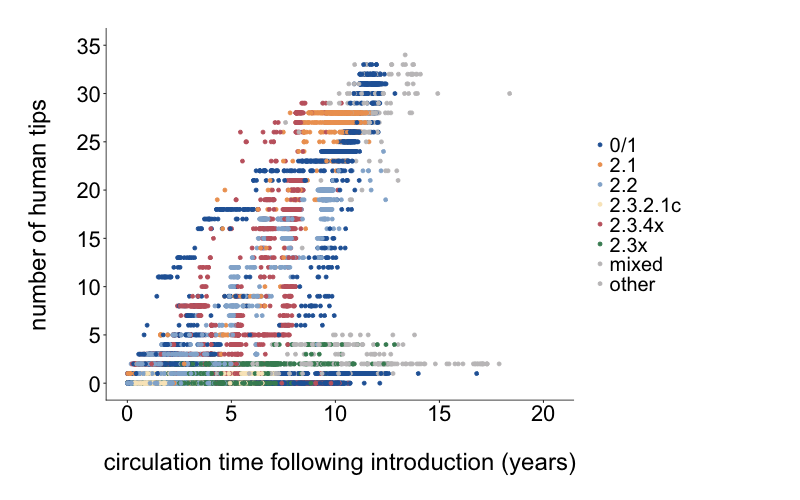

In [36]:
%%R -w 800 -h 500 -u px -i df_with_clade,current_date,clade_0_1_color,clade_2_1_color,clade_2_2_color,clade_2_3_color,clade_2_3_4_color,clade_2_3_2_1c_color,clade_other_color,clade_mixed_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("circulation-time-vs-human-tips-clade-",current_date,".png", sep="")

p <- ggplot(data=df_with_clade, aes(x=circulation_time, y=n_human_tips, color=clade_group), alpha = 0.5) + 
    geom_point()+
    labs(x="\ncirculation time following introduction (years)", y="number of human tips\n")+
    scale_y_continuous(breaks=seq(0,35,5), limits=c(0,35))+
#      scale_x_continuous(breaks=seq(0,15,3), limits=c(0,15))+
    scale_color_manual(values=c("0/1"=clade_0_1_color,"2.1"=clade_2_1_color,"2.2"=clade_2_2_color,"2.3x"=clade_2_3_color, "2.3.2.1c"=clade_2_3_2_1c_color,"2.3.4x"=clade_2_3_4_color,"other"=clade_other_color, "mixed"=clade_mixed_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "png", path = "figures", dpi = 300)
p

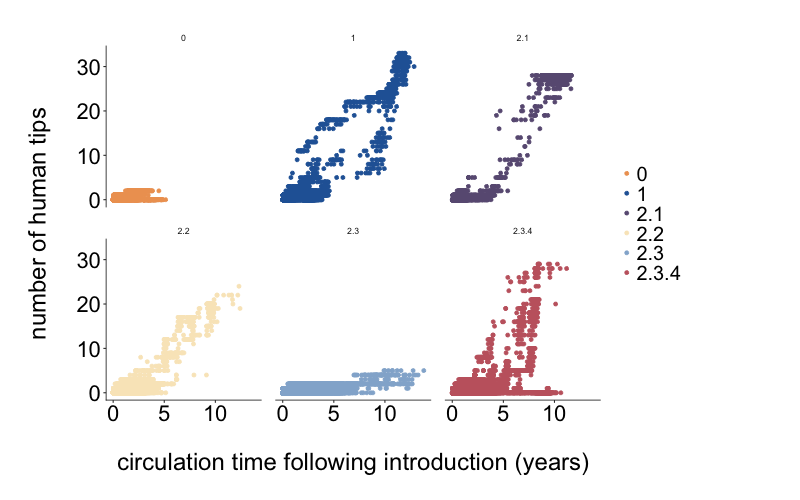

In [126]:
%%R -w 800 -h 500 -u px -i df_with_clade,current_date,clade_0_color,clade_1_color,clade_2_1_color,clade_2_2_color,clade_2_3_color,clade_2_3_4_color,clade_other_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("circulation-time-vs-human-tips-clade-faceted-",current_date,".png", sep="")

p <- ggplot(data=df_with_clade, aes(x=circulation_time, y=n_human_tips, color=clade_group), alpha = 0.5) + 
    geom_point()+
    facet_wrap(~clade_group)+
    labs(x="\ncirculation time following introduction (years)", y="number of human tips\n")+
#      scale_y_continuous(breaks=seq(0,40,5), limits=c(0,40))+
#      scale_x_continuous(breaks=seq(0,15,3), limits=c(0,15))+
    scale_color_manual(values=c("0"=clade_0_color,"1"=clade_1_color,"2.1"=clade_2_1_color,"2.2"=clade_2_2_color,"2.3"=clade_2_3_color, "2.3.4"=clade_2_3_4_color,"other"=clade_other_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "png", path = "figures", dpi = 300)
p

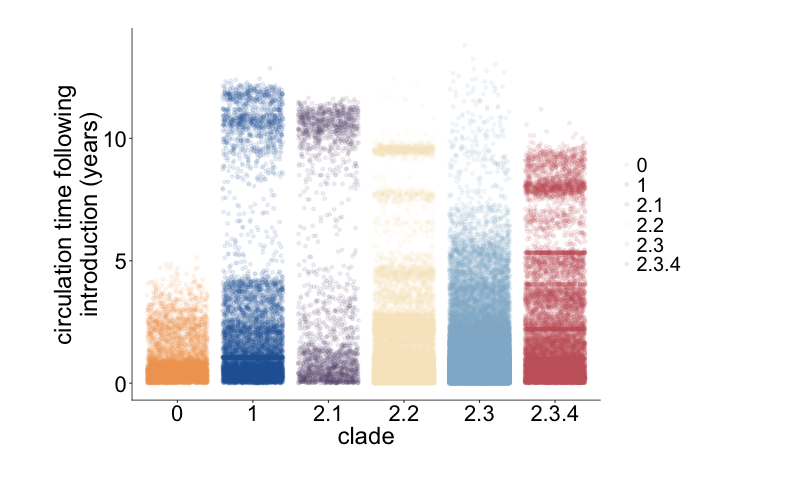

In [137]:
%%R -w 800 -h 500 -u px -i df_with_clade,current_date,clade_0_color,clade_1_color,clade_2_1_color,clade_2_2_color,clade_2_3_color,clade_2_3_4_color,clade_other_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("circulation-time-by-clade-faceted-",current_date,".png", sep="")

p <- ggplot(data=df_with_clade, aes(x=clade_group, y=circulation_time, color=clade_group)) + 
    #geom_density(size=1.5)+
    geom_jitter(alpha=0.1)+
    labs(y="\ncirculation time following\nintroduction (years)", x="clade\n")+
#      scale_y_continuous(breaks=seq(0,40,5), limits=c(0,40))+
#      scale_x_continuous(breaks=seq(0,15,3), limits=c(0,15))+
    scale_color_manual(values=c("0"=clade_0_color,"1"=clade_1_color,"2.1"=clade_2_1_color,"2.2"=clade_2_2_color,"2.3"=clade_2_3_color, "2.3.4"=clade_2_3_4_color,"other"=clade_other_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "png", path = "figures", dpi = 300)
p

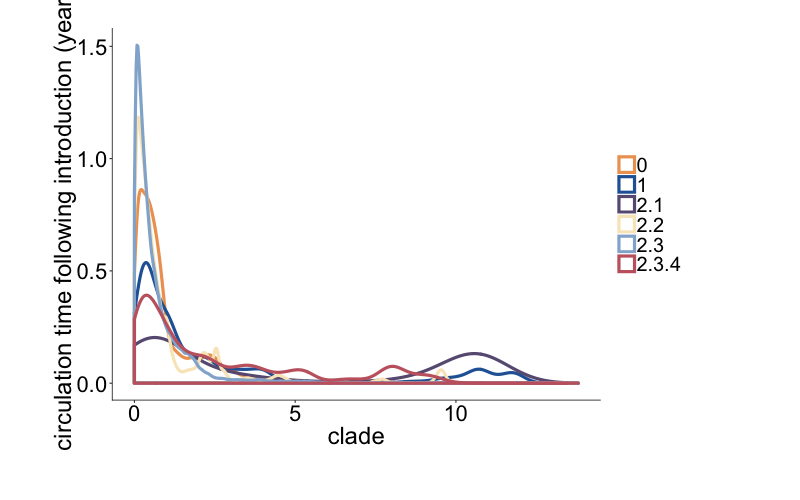

In [134]:
%%R -w 800 -h 500 -u px -i df_with_clade,current_date,clade_0_color,clade_1_color,clade_2_1_color,clade_2_2_color,clade_2_3_color,clade_2_3_4_color,clade_other_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("circulation-time-by-clade-density",current_date,".png", sep="")

p <- ggplot(data=df_with_clade, aes(x=circulation_time, color=clade_group)) + 
    geom_density(size=1.5)+
    labs(x="\ncirculation time following introduction (years)")+
#      scale_y_continuous(breaks=seq(0,40,5), limits=c(0,40))+
#      scale_x_continuous(breaks=seq(0,15,3), limits=c(0,15))+
    scale_color_manual(values=c("0"=clade_0_color,"1"=clade_1_color,"2.1"=clade_2_1_color,"2.2"=clade_2_2_color,"2.3"=clade_2_3_color, "2.3.4"=clade_2_3_4_color,"other"=clade_other_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "png", path = "figures", dpi = 300)
p

In [138]:
# how many of these clusters are found frequently across the posterior 
x = pd.DataFrame(df_with_clade['tips_in_subtree'].value_counts())
print(type(x))
x.reset_index(inplace=True)
x = x.rename(columns={"index":"tips_in_subtree","tips_in_subtree":"times_cluster_in_posterior"})
x.head()

<class 'pandas.core.frame.DataFrame'>


,tips_in_subtree,times_cluster_in_posterior
0,['A/chicken/Shimane/1/2010|2010.833|2010-11-XX...,1133
1,['A/chicken/Subang/08160018-002/2016|2016.019|...,1133
2,['A/chicken/Myanmar/CS-13/2017|2017.959|2017-1...,1130
3,['A/duck/India/03CA01/2015|2015.162|2015-03-XX...,1130
4,['A/duck/Bangladesh/22806/2014|2014.471|2014-0...,1128


In [139]:
print(len(df_with_clade))
merged = df_with_clade.merge(x)
print(len(merged))
merged.head()

152062
152062


,Unnamed: 0,tree_number,subtree_number,circulation_time,n_human_tips,tips_in_subtree,clade_group,region_group,n_tips_in_subtree,human_tips,times_cluster_in_posterior
0,0,1,1,0.705697,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0,China,1,0,936
1,0,3,1,0.208335,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0,China,1,0,936
2,0,4,3,0.813138,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0,China,1,0,936
3,0,5,3,0.681485,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0,China,1,0,936
4,0,6,2,0.550684,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0,China,1,0,936


In [140]:
# subset this to only the unique clusters 
# merged.drop_duplicates('tips_in_subtree', inplace=True)
# merged.reset_index(inplace=True)
# print(len(merged))

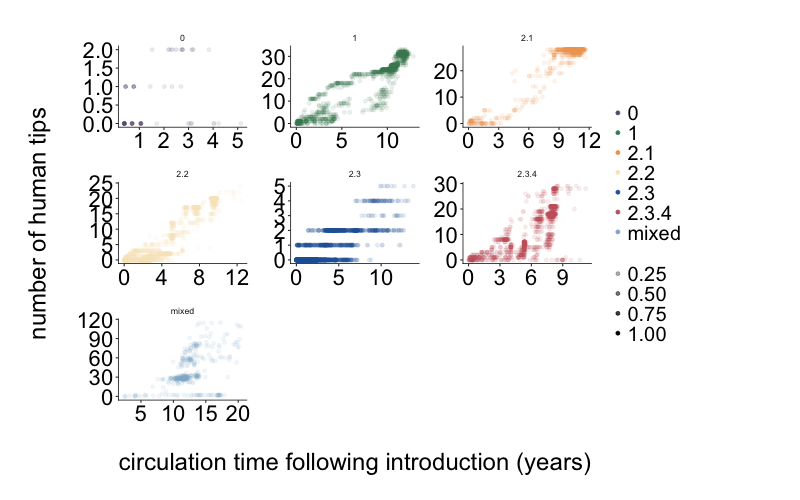

In [102]:
%%R -w 800 -h 500 -u px -i merged,current_date,clade_0_color,clade_1_color,clade_2_1_color,clade_2_2_color,clade_2_3_color,clade_2_3_4_color,clade_mixed_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("circulation-time-vs-human-tips-clade-unique-clusters-faceted-",current_date,".png", sep="")

p <- ggplot(data=merged, aes(x=circulation_time, y=n_human_tips, color=clade_group, alpha=times_cluster_in_posterior/1133)) + 
    geom_point()+
    facet_wrap(~clade_group, scales="free")+
    labs(x="\ncirculation time following introduction (years)", y="number of human tips\n")+
#      scale_y_continuous(breaks=seq(0,40,5), limits=c(0,40))+
#      scale_x_continuous(breaks=seq(0,15,3), limits=c(0,15))+
    scale_color_manual(values=c("0"=clade_0_color,"1"=clade_1_color,"2.1"=clade_2_1_color,"2.2"=clade_2_2_color,"2.3"=clade_2_3_color, "2.3.4"=clade_2_3_4_color,"mixed"=clade_mixed_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 16, height = 12, device = "png", path = "figures", dpi = 300)
p

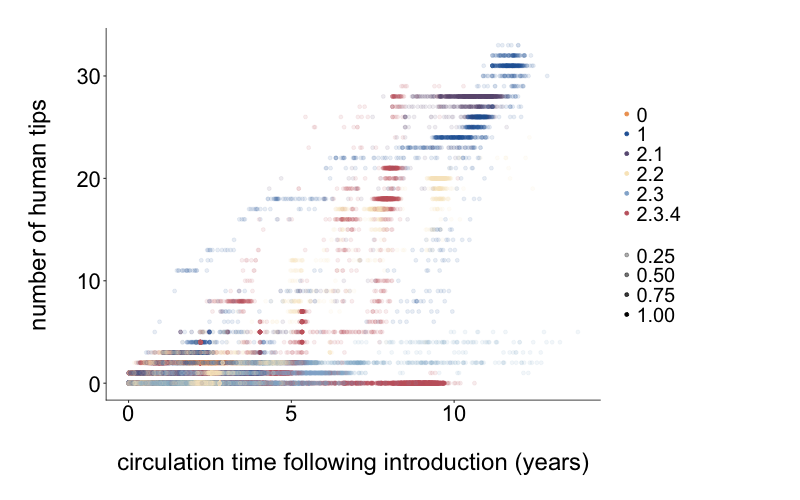

In [141]:
%%R -w 800 -h 500 -u px -i merged,current_date,clade_0_color,clade_1_color,clade_2_1_color,clade_2_2_color,clade_2_3_color,clade_2_3_4_color,clade_mixed_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("circulation-time-vs-human-tips-clade-with-cluster-freq-",current_date,".png", sep="")

p <- ggplot(data=merged, aes(x=circulation_time, y=n_human_tips, color=clade_group, alpha=times_cluster_in_posterior/1133)) + 
    geom_point()+
    labs(x="\ncirculation time following introduction (years)", y="number of human tips\n")+
#      scale_y_continuous(breaks=seq(0,40,5), limits=c(0,40))+
#      scale_x_continuous(breaks=seq(0,15,3), limits=c(0,15))+
    scale_color_manual(values=c("0"=clade_0_color,"1"=clade_1_color,"2.1"=clade_2_1_color,"2.2"=clade_2_2_color,"2.3"=clade_2_3_color, "2.3.4"=clade_2_3_4_color,"mixed"=clade_mixed_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "png", path = "figures", dpi = 300)
p

## Conclusions 

So what all of this is telling me is the following: 

* we have very few clusters that are consistently resolved across the posterior. Even requiring the cluster to be present in at least 10% of sampled trees eliminated about half of the clusters. Requiring the clusters to be in 50% of trees eliminated 75% of the clusters. 
* in some ways this makes sense, because there are going to be small differences in where the cross species transmission event gets called, and there will be times when a wacky tree happens, where there are way too many inferred human tips. A cluster will be different even if a single tip is different (so for example, if the cross-species transmission branch is moved 1 more basal or 1 more terminal). 
* leafing through the posterior, there are a few odd trees where too much of interior backbone is inferred as domestic, and then you get transmission back into wild.This is what causes the huge clusters with tons of human tips. 
* for the regression, I'm not sure that this is a problem, because more probable clusters will be present more frequently in the dataframe that we are regressing on. For visualization though, it might bbe good to have a way to show how well supported the clusters are. 

## Plotting: tips/introduction by clade

In [19]:
df_with_clade.head()

,Unnamed: 0,tree_number,subtree_number,circulation_time,n_human_tips,tips_in_subtree,clade_group,region_group,n_tips_in_subtree,human_tips
0,0,1,1,0.705697,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0,China,1,0
1,0,3,1,0.208335,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0,China,1,0
2,0,4,3,0.813138,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0,China,1,0
3,0,5,3,0.681485,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0,China,1,0
4,0,6,2,0.550684,0,['A/Goose/Guangdong/1/1996|1996.0|1996-XX-XX|A...,0,China,1,0


In [20]:
# clade_colors 
clade_2_3_4_color="#C5656E"
clade_1_color="#2664A5"
clade_2_1_color="#695B82"
clade_2_2_color="#F9E7C3"
clade_2_3_color="#93B2D2"
clade_0_color="#EEA160"
clade_other_color="#438B62"

In [21]:
# remove rows with other; these are all very small clades that are sort of odd, and I don't think we need to include them 
print(len(df_with_clade))
df_with_clade2 = df_with_clade[df_with_clade['clade_group']!='other']
df_with_clade2 = df_with_clade[df_with_clade['clade_group']!='mixed']

print(len(df_with_clade2))

161168
160734


In [22]:
tips_in_tree_per_clade_group = {'2.3': 183, '2.3.4': 67, '2.2': 164, 'other': 17, '2.1': 40, '1': 72, '0': 6}

In [27]:
intros_per_clade_per_tree = pd.DataFrame()
intros_per_tree = pd.DataFrame()

for tree in set(df_with_clade['tree_number'].tolist()):
    local_df = df_with_clade[df_with_clade['tree_number'] == tree]
    n_intros_in_tree = len(local_df)
    new_row1 = pd.DataFrame({"tree_number":[tree], "n_intros":n_intros_in_tree})
    intros_per_tree = intros_per_tree.append(new_row1)
    
    for clade in tips_in_tree_per_clade_group:
        n_intros = len(local_df[local_df['clade_group'] == clade])
        
        if n_intros > 0:
            tips_over_intros = tips_in_tree_per_clade_group[clade]/n_intros
        
            new_row = pd.DataFrame({"tree_number":[tree], "clade_group":clade, "n_intros":n_intros, 
                                    "tips_over_intros":tips_over_intros})
            
            intros_per_clade_per_tree = intros_per_clade_per_tree.append(new_row)

intros_per_clade_per_tree.head()

,tree_number,clade_group,n_intros,tips_over_intros
0,1,2.3,88,2.079545
0,1,2.3.4,5,13.400000
0,1,2.2,20,8.200000
0,1,other,6,2.833333
0,1,1,4,18.000000


In [28]:
intros_per_tree.head()

,tree_number,n_intros
0,1,129
0,2,129
0,3,165
0,4,135
0,5,151


In [66]:
import pymc3
from scipy.stats import norm
hpd = pymc3.stats.hpd(intros_per_tree['n_intros'])
lower_hpd = hpd[0]
upper_hpd = hpd[1]
print(min(intros_per_tree['n_intros']), max(intros_per_tree['n_intros']))
print(hpd)

64 212
[ 94 178]


 ## Total intros (regardless of clade) across the posterior 

In [31]:
n_trees_in_posterior = len(intros_per_tree)
print(n_trees_in_posterior)

1133


In [46]:
# convert to proportions for plotting
counts_per_intro_size = pd.DataFrame(intros_per_tree['n_intros'].value_counts())
counts_per_intro_size.reset_index(inplace=True)
counts_per_intro_size.rename(columns={"index":"n_intros","n_intros":"number_of_trees"}, inplace=True)
counts_per_intro_size["proportion_trees"] = counts_per_intro_size['number_of_trees']/n_trees_in_posterior
counts_per_intro_size['n_intros'] = pd.to_numeric(counts_per_intro_size['n_intros'])
counts_per_intro_size.head()

,n_intros,number_of_trees,proportion_trees
0,144,32,0.028244
1,149,27,0.023831
2,146,26,0.022948
3,153,26,0.022948
4,154,25,0.022065


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


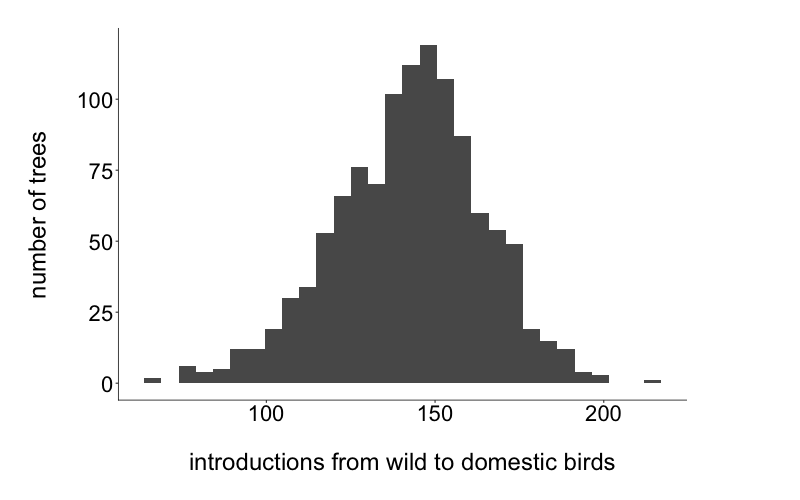

In [51]:
%%R -w 800 -h 500 -u px -i intros_per_tree,current_date,clade_0_color,clade_1_color,clade_2_1_color,clade_2_2_color,clade_2_3_color,clade_2_3_4_color,clade_other_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("intros-over-posterior-",current_date,".png", sep="")

p <- ggplot(data=intros_per_tree, aes(x=n_intros)) + 
    geom_histogram()+
    #facet_wrap(~clade_group, scales="free")+
    labs(x="\nintroductions from wild to domestic birds", y="number of trees\n")+
    #scale_y_continuous(breaks=seq(0,1,0.1), limits=c(0,1))+
    #scale_x_continuous(breaks=seq(0,15,3), limits=c(0,15))+
    scale_color_manual(values=c("0"=clade_0_color,"1"=clade_1_color,"2.1"=clade_2_1_color,"2.2"=clade_2_2_color,"2.3"=clade_2_3_color, "2.3.4"=clade_2_3_4_color,"other"=clade_other_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 6, device = "png", path = "figures", dpi = 300)
p

In [72]:
# colorby hpd 
in_hpd = counts_per_intro_size[(counts_per_intro_size['n_intros'] >= lower_hpd)&((counts_per_intro_size['n_intros'] <= upper_hpd))]
not_in_hpd = counts_per_intro_size[~((counts_per_intro_size['n_intros'] >= lower_hpd)&((counts_per_intro_size['n_intros'] <= upper_hpd)))]

#counts_per_intro_size['colorby'] = np.where(counts_per_intro_size['n_intros'] >= lower_hpd, "95% hpd","not")
in_hpd['colorby'] = 'in_hpd'
not_in_hpd['colorby'] = 'not'

print(len(counts_per_intro_size), len(in_hpd), len(not_in_hpd), len(in_hpd)+len(not_in_hpd))
#counts_per_intro_size.head()

118 85 33 118


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [74]:
counts_per_intro_size_w_colorby = in_hpd.append(not_in_hpd)
counts_per_intro_size_w_colorby.head()

,n_intros,number_of_trees,proportion_trees,colorby
0,144,32,0.028244,in_hpd
1,149,27,0.023831,in_hpd
2,146,26,0.022948,in_hpd
3,153,26,0.022948,in_hpd
4,154,25,0.022065,in_hpd


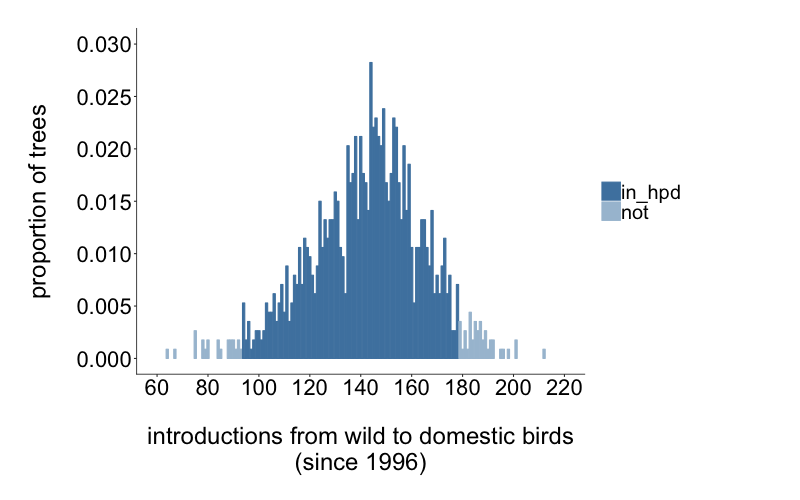

In [79]:
%%R -w 800 -h 500 -u px -i counts_per_intro_size_w_colorby,current_date,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("intros-over-posterior-",current_date,".png", sep="")

p <- ggplot(data=counts_per_intro_size_w_colorby, aes(x=n_intros, y=proportion_trees, color=colorby, fill=colorby)) + 
    geom_col()+
    #facet_wrap(~clade_group, scales="free")+
    labs(x="\nintroductions from wild to domestic birds\n(since 1996)", y="proportion of trees\n")+
    scale_y_continuous(breaks=seq(0,0.03,0.005), limits=c(0,0.03))+
    scale_x_continuous(breaks=seq(60,220,20), limits=c(60,220))+
    scale_color_manual(values=c(in_hpd=domestic_color,not="#A7C1D6"))+
    scale_fill_manual(values=c(in_hpd=domestic_color,not="#A7C1D6"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 6, device = "png", path = "figures", dpi = 300)
p

### Overall introductions: 

These estimates are somewhat diffuse, with a 95% HPD of 94-178. This tree spans from 1996-2019 = 23 years of data. So we estimate anywhere from 4-8 introductions on average per year. This is definitely not constant over time, but is sort of a high rate of introductions. There is definitely some real noise in the data, because inferring the introductions is not completely resolved across the posterior. However, this feels like a reasonable enough estimate to report to me. 

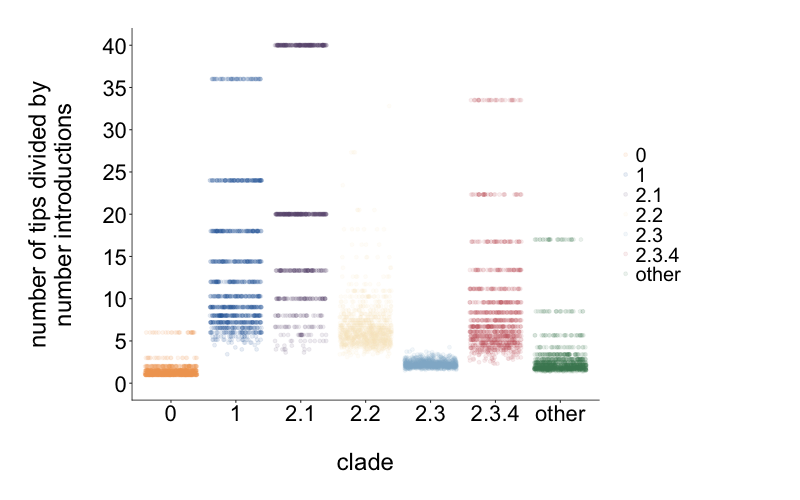

In [97]:
%%R -w 800 -h 500 -u px -i output_df,current_date,clade_0_color,clade_1_color,clade_2_1_color,clade_2_2_color,clade_2_3_color,clade_2_3_4_color,clade_other_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("tips-per-intro-by-clade-",current_date,".png", sep="")

p <- ggplot(data=output_df, aes(x=clade_group, y=tips_over_intros, color=clade_group), alpha = 0.3) + 
    geom_jitter(alpha=0.1)+
    #facet_wrap(~clade_group, scales="free")+
    labs(x="\nclade", y="number of tips divided by\nnumber introductions\n")+
    scale_y_continuous(breaks=seq(0,40,5), limits=c(0,40))+
#      scale_x_continuous(breaks=seq(0,15,3), limits=c(0,15))+
    scale_color_manual(values=c("0"=clade_0_color,"1"=clade_1_color,"2.1"=clade_2_1_color,"2.2"=clade_2_2_color,"2.3"=clade_2_3_color, "2.3.4"=clade_2_3_4_color,"other"=clade_other_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 6, device = "png", path = "figures", dpi = 300)
p

## Control: is the number of introductions correlated with the number of wild sequences per clade? 

In [106]:
tips_per_host_per_clade = {'2.3': {'human': 7, 'domestic': 132, 'wild': 44, 'total': 183}, 
                           '2.3.4': {'human': 29, 'domestic': 31, 'wild': 7, 'total': 67}, 
                           '2.2': {'human': 24, 'domestic': 112, 'wild': 28, 'total': 164}, 
                           'other': {'human': 2, 'domestic': 13, 'wild': 2, 'total': 17}, 
                           '2.1': {'human': 28, 'domestic': 12, 'wild': 0, 'total': 40}, 
                           '1': {'human': 33, 'domestic': 29, 'wild': 10, 'total': 72}, 
                           '0': {'human': 2, 'domestic': 4, 'wild': 0, 'total': 6}}

control_df = pd.DataFrame.from_dict(tips_per_host_per_clade, orient="index")
control_df.reset_index(inplace=True)
control_df.rename(columns = {"index":"clade_group"}, inplace=True)
control_df.head()

,clade_group,human,domestic,wild,total
0,2.3,7,132,44,183
1,2.3.4,29,31,7,67
2,2.2,24,112,28,164
3,other,2,13,2,17
4,2.1,28,12,0,40


In [108]:
control_df2 = output_df.merge(control_df, on="clade_group")
control_df2.head()

,tree_number,clade_group,n_intros,tips_over_intros,human,domestic,wild,total
0,1,2.3,88,2.079545,7,132,44,183
1,2,2.3,77,2.376623,7,132,44,183
2,3,2.3,99,1.848485,7,132,44,183
3,4,2.3,82,2.231707,7,132,44,183
4,5,2.3,82,2.231707,7,132,44,183


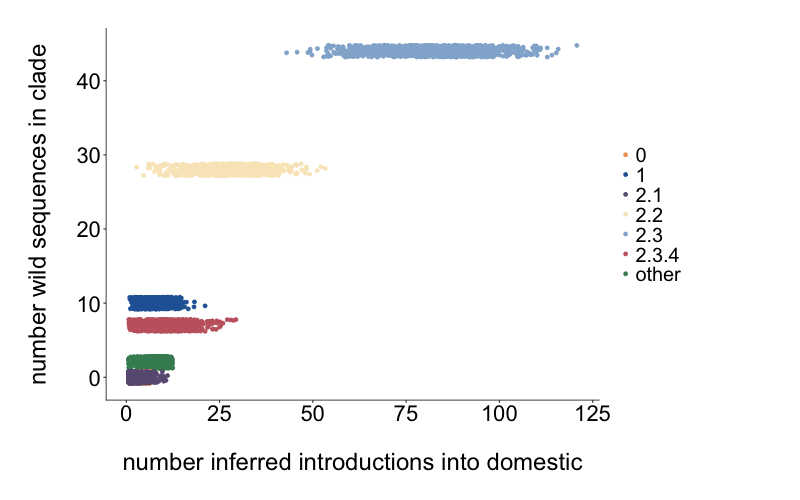

In [111]:
%%R -w 800 -h 500 -u px -i control_df2,current_date,clade_0_color,clade_1_color,clade_2_1_color,clade_2_2_color,clade_2_3_color,clade_2_3_4_color,clade_other_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("intros-vs-wild-seqs-",current_date,".png", sep="")

p <- ggplot(data=control_df2, aes(x=n_intros, y=wild, color=clade_group)) + 
    geom_jitter()+
    #facet_wrap(~clade_group, scales="free")+
    labs(x="\nnumber inferred introductions into domestic", y="number wild sequences in clade\n")+
#     scale_y_continuous(breaks=seq(0,40,5), limits=c(0,40))+
#      scale_x_continuous(breaks=seq(0,15,3), limits=c(0,15))+
    scale_color_manual(values=c("0"=clade_0_color,"1"=clade_1_color,"2.1"=clade_2_1_color,"2.2"=clade_2_2_color,"2.3"=clade_2_3_color, "2.3.4"=clade_2_3_4_color,"other"=clade_other_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 6, device = "png", path = "figures", dpi = 300)
p

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


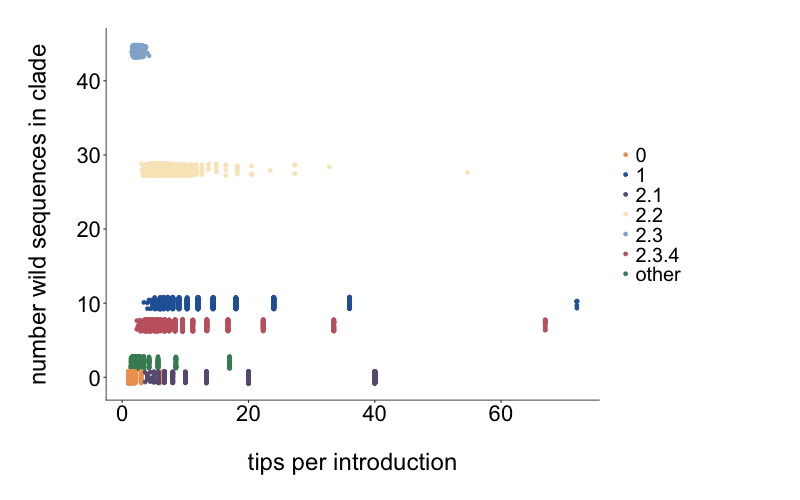

In [115]:
%%R -w 800 -h 500 -u px -i control_df2,current_date,clade_0_color,clade_1_color,clade_2_1_color,clade_2_2_color,clade_2_3_color,clade_2_3_4_color,clade_other_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("tips-per-intro-vs-wild-seqs-",current_date,".png", sep="")

p <- ggplot(data=control_df2, aes(x=tips_over_intros, y=wild, color=clade_group)) + 
    geom_jitter()+
    #facet_wrap(~clade_group, scales="free")+
    labs(x="\ntips per introduction", y="number wild sequences in clade\n")+
#     scale_y_continuous(breaks=seq(0,40,5), limits=c(0,40))+
#      scale_x_continuous(breaks=seq(0,15,3), limits=c(0,15))+
    scale_color_manual(values=c("0"=clade_0_color,"1"=clade_1_color,"2.1"=clade_2_1_color,"2.2"=clade_2_2_color,"2.3"=clade_2_3_color, "2.3.4"=clade_2_3_4_color,"other"=clade_other_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 6, device = "png", path = "figures", dpi = 300)
p

In [113]:
%%R -w 800 -h 500 -u px -i control_df2

reg1 <- lm(n_intros~wild,data=control_df2) 
reg2 <- lm(tips_over_intros~wild,data=control_df2) 

print(summary(reg1))
print(summary(reg2))

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



Call:
lm(formula = n_intros ~ wild, data = control_df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.400  -6.609   2.391   5.655  50.854 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.655150   0.163245  -4.013 6.04e-05 ***
wild         1.609126   0.007979 201.668  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.97 on 7774 degrees of freedom
Multiple R-squared:  0.8395,	Adjusted R-squared:  0.8395 
F-statistic: 4.067e+04 on 1 and 7774 DF,  p-value: < 2.2e-16


Call:
lm(formula = tips_over_intros ~ wild, data = control_df2)

Residuals:
   Min     1Q Median     3Q    Max 
-9.860 -7.678 -1.188  1.167 62.881 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.85979    0.14975   72.52   <2e-16 ***
wild        -0.17411    0.00732  -23.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.06 on 7